## Replicate Ankita analysis

In [4]:
from tqdm import tqdm
import os
import json
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
from pathlib import Path

In [5]:
def linear_CKA(X, Y):
    X_centered = X - X.mean(axis=0)
    Y_centered = Y - Y.mean(axis=0)
    hsic = np.linalg.norm(X_centered.T @ Y_centered, 'fro') ** 2
    var1 = np.linalg.norm(X_centered.T @ X_centered, 'fro')
    var2 = np.linalg.norm(Y_centered.T @ Y_centered, 'fro')

    return hsic / (var1 * var2)

In [6]:
# Commented because we already have the results

with open(os.path.join('../../../experiments/layers/embeddings_layer0_glove.json'), 'r') as f:
    glove_list = json.load(f)
glove_matrix = np.array(glove_list)

# wav_vs_glove = []
# for i in range(12):
#     with open(os.path.join('../../..', 'experiments', 'layers', f'embeddings_layer{i}_wav2vec2.json'), 'r') as f:
#         model1_list = json.load(f)
#     model1_matrix = np.array(model1_list)
#     wav_vs_glove.append(linear_CKA(model1_matrix, glove_matrix)) 

#     del model1_list, model1_matrix
#     gc.collect()
   
# with open(f'cka_glove_wav2vec2.json', 'w') as f:
#     json.dump(wav_vs_glove, f)

In [7]:
file_path = Path('cka_glove_wav2vec2.json')

with file_path.open('r', encoding='utf-8') as file:
    wav_vs_glove = json.load(file)

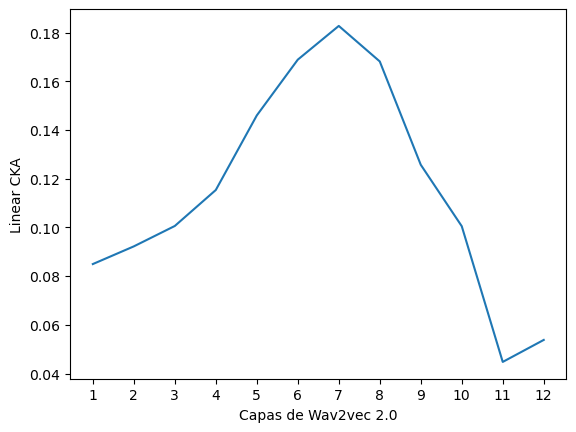

In [8]:
x = range(1,13)
plt.plot(x, wav_vs_glove, label='wav_vs_glove')

plt.xlabel('Capas de Wav2vec 2.0')
plt.ylabel('Linear CKA')
plt.xticks(range(1,13)) 
plt.show()

## CKA: Learning Curve

In [9]:
x_list = []
for i in range(12):
    with open(os.path.join('../../..', 'experiments', 'layers', f'embeddings_layer{i}_wav2vec2.json'), 'r') as f:
        model1_list = json.load(f)
    x_matrix = np.array(model1_list)
    x_list.append(x_matrix) 


In [10]:
matrix = np.zeros((15, 12))
for i in tqdm(range(3000, 46000, 3000)):
    index = int((i-3000)/3000)
    for j in tqdm(range(12)): 
        x = x_list[j]
        matrix[index, j] = linear_CKA(x[0:i], glove_matrix[0:i])

100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


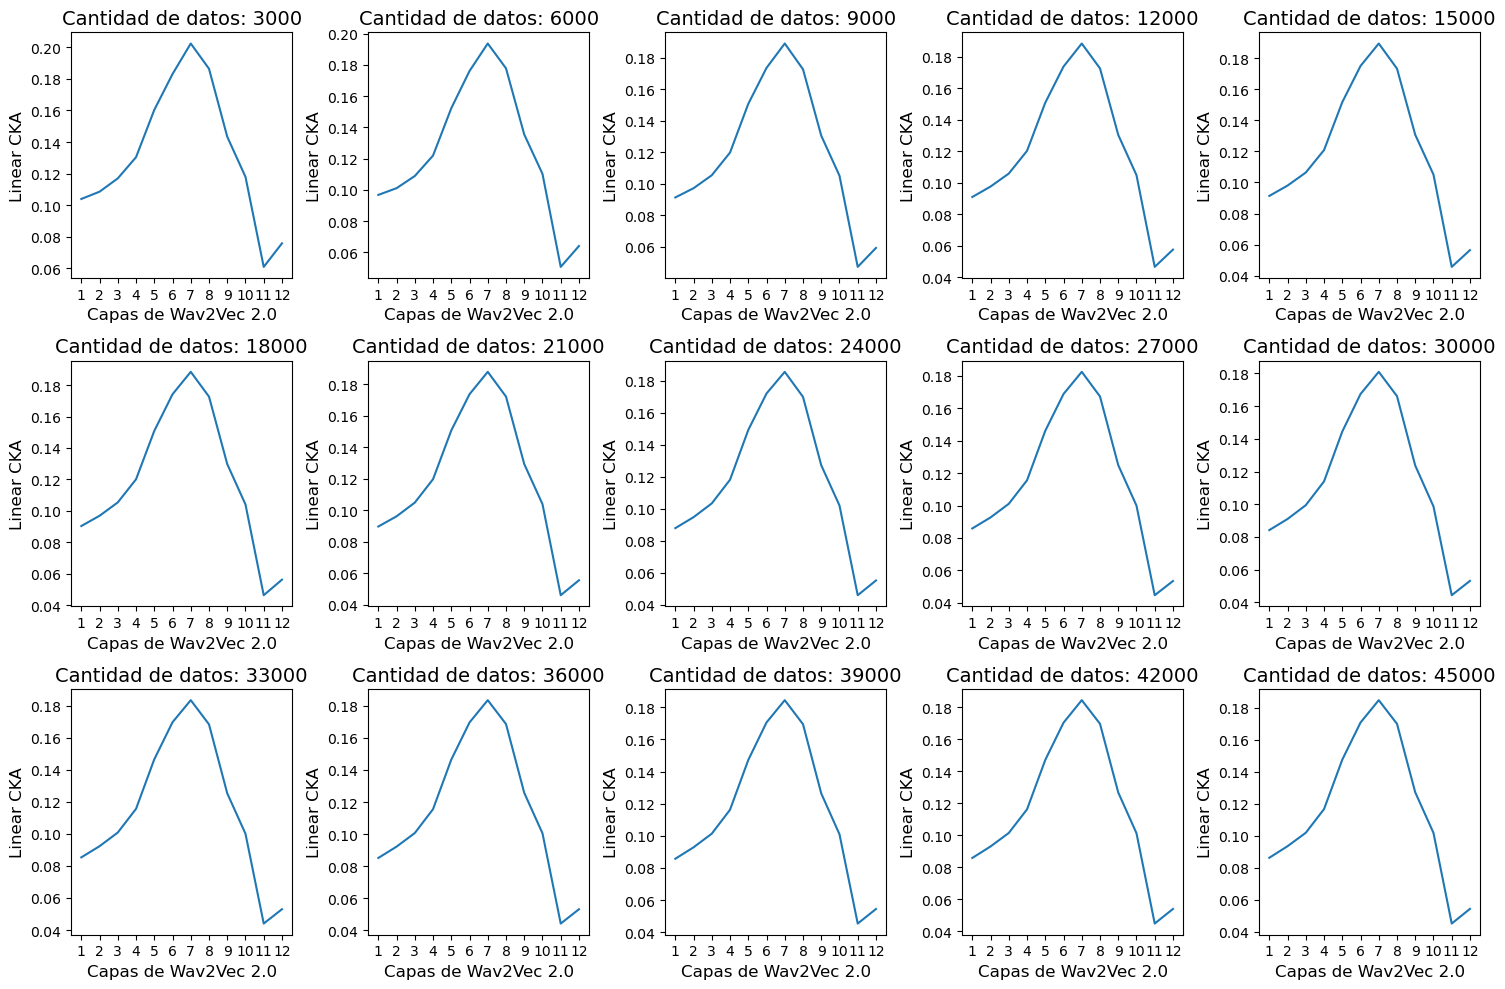

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10))  # Adjust figsize to fit your screen and needs

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i in range(15):
    x = range(1, 13)  # Layers 1 to 11
    axes[i].plot(x, matrix[i], label='wav_vs_glove')
    axes[i].set_xlabel('Capas de Wav2Vec 2.0', fontsize=12)  # Increase fontsize for x-label
    axes[i].set_ylabel('Linear CKA', fontsize=12)  # Increase fontsize for y-label
    axes[i].set_title(f'Cantidad de datos: {(i+1)*3000}', fontsize=14)  # Increase fontsize for title
    axes[i].set_xticks(range(1, 13))  # Ticks en X de 1 a 12
    axes[i].tick_params(axis='both', which='major', labelsize=10)  # Increase tick label size

plt.tight_layout()
plt.show()

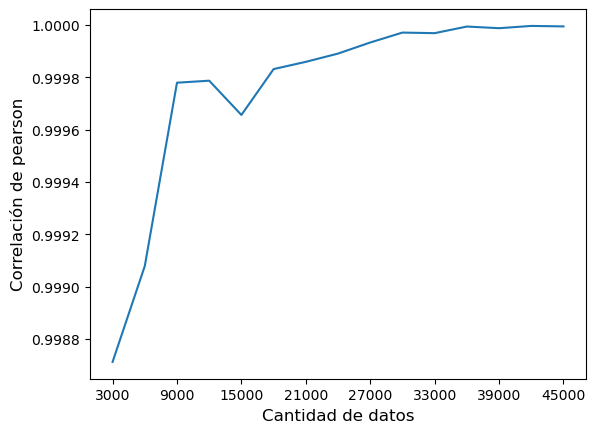

In [14]:
pearson_corr = []
for i in range(matrix.shape[0]):
    pearson_corr.append(stats.pearsonr(wav_vs_glove, matrix[i]).statistic)

plt.plot(range(3000, 46000, 3000), pearson_corr)
plt.xlabel('Cantidad de datos',  fontsize=12)
plt.ylabel('Correlación de pearson', fontsize=12)
plt.xticks(range(3000, 46000, 6000)) 
plt.show()

## CKA vs CCA

In [23]:
# # Running this cell in Colab because we don't have enough computational resources locally resulted in an error due to insufficient compute power.

# import os
# os.environ['OMP_NUM_THREADS']='8' #Cantidad de threads a usar por sklearn
# os.nice(10) #Prioridad de los procesos -20: highest 20: lowest 0: default

# wav_vs_glove_CCA = []
# with open(os.path.join('../experiments/layers/embeddings_layer0_glove.json'), 'r') as f:
#     glove_list = json.load(f)
# glove_matrix = np.array(glove_list)

# for i in range(12):
#     x = x_list[i]
#     model1_matrix = np.array(model1_list)
#     model = CCA(n_components=300)
#     model.fit(x[0:3000],glove_matrix[0:3000])
#     X_c, Y_c = model.transform(x[0:3000], glove_matrix[0:3000])
#     correlations = np.corrcoef(X_c.T, Y_c.T).diagonal(offset=X_c.shape[1])
#     mean_correlation = np.mean(correlations)
#     wav_vs_glove_CCA.append(mean_correlation)  

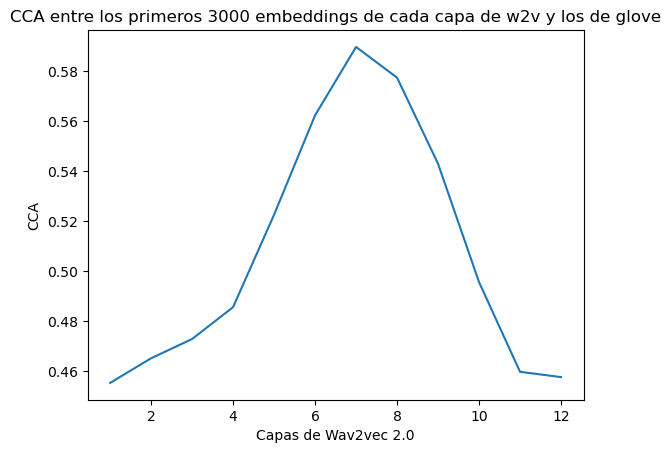

In [18]:
wav_vs_glove_CCA = [0.4552785903820065,
 0.46515271583991935,
 0.4728577455210156,
 0.4856241870508816,
 0.52264089080444,
 0.5624277531077105,
 0.5898141105294815,
 0.5775077350128057,
 0.5430461697056727,
 0.49564927266548353,
 0.45973128155226173,
 0.4576064483370868]

x = range(1,13)
plt.plot(x, wav_vs_glove_CCA, label='wav_vs_glove')

plt.xlabel('Capas de Wav2vec 2.0')
plt.ylabel('CCA')
plt.title('CCA entre los primeros 3000 embeddings de cada capa de w2v y los de glove')
plt.show()

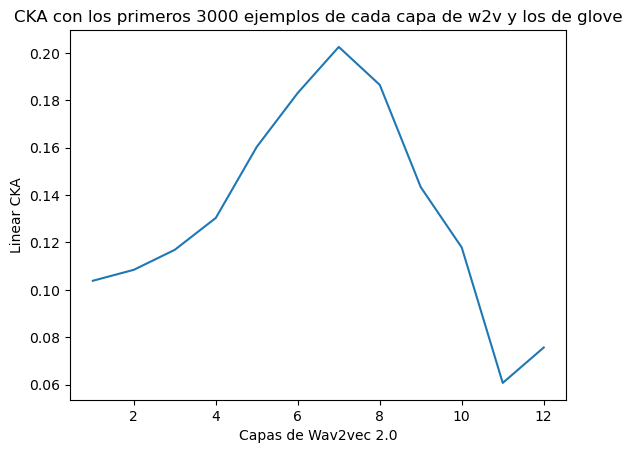

In [19]:
x = range(1,13)
plt.plot(x, matrix[0], label='wav_vs_glove')

plt.xlabel('Capas de Wav2vec 2.0')
plt.ylabel('Linear CKA')
plt.title('CKA con los primeros 3000 ejemplos de cada capa de w2v y los de glove')
plt.show()

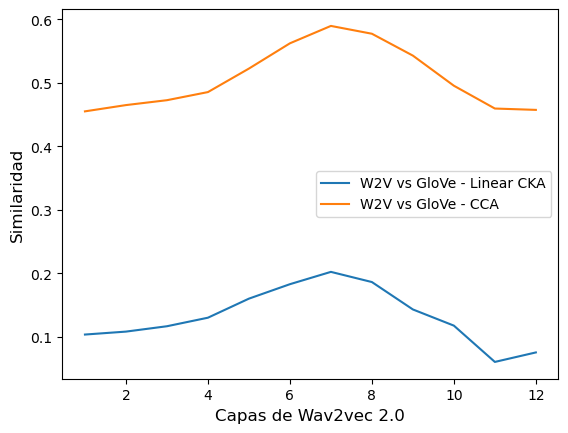

In [20]:
x = range(1,13)
plt.plot(x, matrix[0], label='W2V vs GloVe - Linear CKA')
plt.plot(x, wav_vs_glove_CCA, label='W2V vs GloVe - CCA')

plt.xlabel('Capas de Wav2vec 2.0', fontsize=12)
plt.ylabel('Similaridad',  fontsize=12)
plt.legend()
plt.show()